# Are houses in college towns more recession proof?
#### Mo Ghahramani


I study the effect of recession on the average value of houses in college towns in United States. 
More specifically, I try to answer, with high confidence, whether houses in college towns hold their value better than those outside college town during a recession. 
To compare the house prices between the two groups, I define a parameter called "Price Ratio" which is the mean value of houses the quarter before the recession starts divided by mean value of houses at recession bottom. The mean "Price Ratio" is then compared for the two groups using a statistical two sample t-test to draw conclusion.

Price Ratio = value of house before recession / value of house at recession bottom

1 means no change

$>$1 means house lost value (BAD!)

$<$1 means house gained value)

Data:
* From [Zillow research data site,](http://www.zillow.com/research/data/) [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), 
* From the Wikipedia, [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States)
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

## Helper functions & data cleaning

In [2]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. '''

    df = (pd.read_table('data/university_towns.txt', header=None) )
    states_df= df[(df[0].str.endswith('[edit]'))]
    states_df = states_df.applymap(lambda x: str(x).replace('[edit]', ''))
    states_l = list(states_df[0])
    states_idx = states_df.index
    new_idx = [x-i for i,x in enumerate(states_idx)]
    states_df = pd.DataFrame(states_l, index=new_idx)
    towns_df = df[~(df[0].str.endswith('[edit]'))]
    towns_df = towns_df.applymap(lambda x:x.split("(")[0].rstrip())
    towns_df = towns_df.reset_index(drop=True)
    states_df = states_df.reindex(towns_df.index).ffill()
    st_reg_df = pd.concat([states_df, towns_df], axis=1)
    st_reg_df.columns = ['State', 'RegionName']
    st_reg_df = st_reg_df.set_index(["State", "RegionName"])
    
    return st_reg_df
#get_list_of_university_towns()

In [3]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time'''
    
    df = pd.read_excel('data/gdplev.xls', skiprows=7)
    df = df[['Unnamed: 4', 'Unnamed: 6']]
    df.columns = ['Q','GDP']
    df = df[(df['Q'] >= '2000q1')]
    df = df.reset_index(drop=True)
    df['GDP_pct_change'] = df.GDP.pct_change()
    neg_growth_idx = []
    for index, row in df.iterrows():
            if row['GDP_pct_change'] < 0:
                neg_growth_idx.append(index)

    for idx, val in enumerate(neg_growth_idx[:-1]):
        if neg_growth_idx[idx+1] - val == 1:
            rec_start_idx=val
            break

    return df.loc[rec_start_idx-1,'Q']
#get_recession_start()

In [4]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time'''
    
    df = pd.read_excel('data/gdplev.xls', skiprows=7)
    df = df[['Unnamed: 4', 'Unnamed: 6']]
    df.columns = ['Q','GDP']
    df = df[(df['Q'] >= '2000q1')]
    df = df.reset_index(drop=True)
    df['GDP_pct_change'] = df.GDP.pct_change()   
    rec_start_idx = (df.Q==get_recession_start()).idxmax()
    pos_growth_idx = []
    
    for index, row in df.iterrows():
        if index> rec_start_idx and row['GDP_pct_change'] > 0:
            pos_growth_idx.append(index)

    for idx, val in enumerate(pos_growth_idx[:-1]):
        if pos_growth_idx[idx+1] - val == 1:
            rec_end_idx=val+1
            break
       
    return  df.loc[rec_end_idx,'Q']
#get_recession_end()

In [5]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [6]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom'''
    
    df = pd.read_excel('data/gdplev.xls', skiprows=7)
    df = df[['Unnamed: 4', 'Unnamed: 6']]
    df.columns = ['Q','GDP']
    df = df[(df['Q'] >= '2000q1')]
    df = df.reset_index(drop=True)  
    rec_start_q, rec_end_q = get_recession_start(), get_recession_end()
    rec_start_idx, rec_end_idx = (df.Q==rec_start_q).idxmax(), (df.Q==rec_end_q).idxmax()   
    return df.loc[df.index[df.loc[df.index[rec_start_idx:rec_end_idx+1], 'GDP'].idxmin()], 'Q']
#get_recession_bottom()

In [7]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe.
    '''
    data = pd.read_csv('data/City_Zhvi_AllHomes.csv')
    data.drop(data.columns[[0,3,4,5]], axis=1, inplace=True)
    data.drop(data.columns[2:47], axis=1, inplace=True)
    data.State = data.State.map(states)
    data.set_index(['State', 'RegionName'], inplace=True)
    df = data.groupby(pd.PeriodIndex(data.columns, freq='Q'), axis=1).mean()
    return df.sort_index()
#convert_housing_data_to_quarters()

In [8]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    '''
    housing = convert_housing_data_to_quarters()
    housing.columns = ['2000Q1', '2000Q2', '2000Q3', '2000Q4', '2001Q1', '2001Q2',
             '2001Q3', '2001Q4', '2002Q1', '2002Q2', '2002Q3', '2002Q4',
             '2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
             '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
             '2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
             '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
             '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
             '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
             '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
             '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
             '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
             '2016Q3']
    q_s_r = get_recession_start().upper()
    q_b_r = get_recession_bottom().upper()
    housing = housing[[q_s_r, q_b_r]]
    
    housing["price_ratio"] = housing[q_s_r].div(housing[q_b_r])
    housing = housing.dropna()
    ct_h = (pd.merge(get_list_of_university_towns(), housing, how = "inner",
                                  left_index = True, right_index = True))
    non_ct_h = housing[~housing.index.isin(ct_h.index)]
    
    t_stat, p_value = ttest_ind(ct_h["price_ratio"],
                                      non_ct_h["price_ratio"])
    if p_value < 0.01:
        different = True
    else:
        different = False
    if t_stat < 0:
        better = "university town"
    else:
        better = "non-university town"
    return (different, p_value, better)

run_ttest()

(True, 0.002724063704761164, 'university town')

In [9]:
housing = convert_housing_data_to_quarters()
housing.columns = ['2000Q1', '2000Q2', '2000Q3', '2000Q4', '2001Q1', '2001Q2',
             '2001Q3', '2001Q4', '2002Q1', '2002Q2', '2002Q3', '2002Q4',
             '2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
             '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
             '2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
             '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
             '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
             '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
             '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
             '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
             '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
             '2016Q3']
q_s_r = get_recession_start().upper()
q_b_r = get_recession_bottom().upper()
housing = housing[[q_s_r, q_b_r]]
housing["price_ratio"] = housing[q_s_r].div(housing[q_b_r])
housing = housing.dropna()
ct_h = (pd.merge(get_list_of_university_towns(), housing, how = "inner",
                                  left_index = True, right_index = True))
non_ct_h = housing[~housing.index.isin(ct_h.index)]

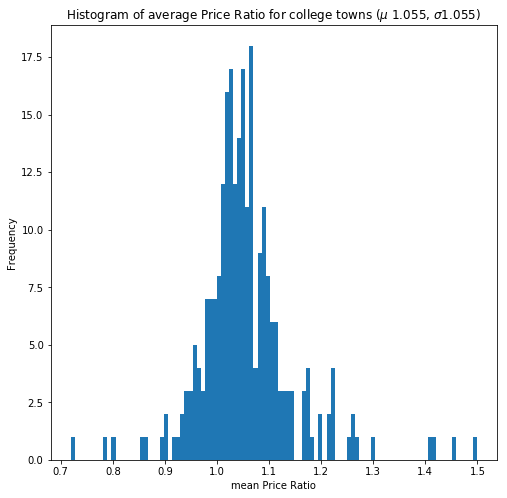

In [10]:
plt.figure(figsize=(8,8))
plt.hist(ct_h.price_ratio.values, 100 )
plt.title('Histogram of average Price Ratio for college towns ($\mu$ {0:.3f}, $\sigma${0:.3f})'
          .format(np.mean(ct_h.price_ratio.values), np.std(ct_h.price_ratio.values)))
plt.ylabel('Frequency')
plt.xlabel('mean Price Ratio')
plt.show()

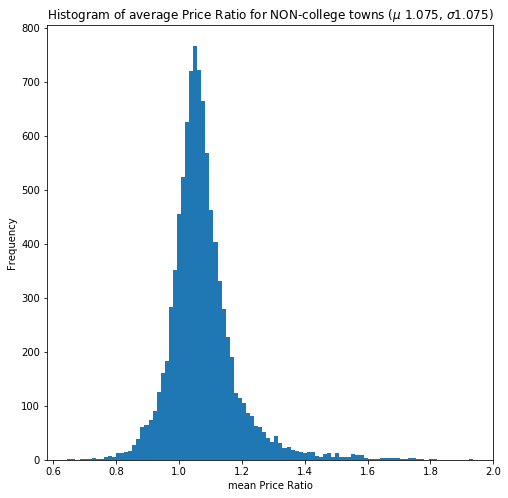

In [11]:
plt.figure(figsize=(8,8))
plt.hist(non_ct_h.price_ratio.values, 100 )
plt.title('Histogram of average Price Ratio for NON-college towns ($\mu$ {0:.3f}, $\sigma${0:.3f})'
          .format(np.mean(non_ct_h.price_ratio.values), np.std(non_ct_h.price_ratio.values)))
plt.ylabel('Frequency')
plt.xlabel('mean Price Ratio')
plt.show()